<h1>3. Machine Learning for Classification</h1>
Using logistic regression to predict churn

Dataset: [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn)

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [203]:
df = pd.read_csv('../datasets/telco_customer_churn.csv')
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [204]:
# clean up column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# clean up data inside categorical columns (object type)
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [205]:
df.head().T # trick to look at all columns if data is wide

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [206]:
# check data types and clean up any irregularities
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [207]:
df.totalcharges # looks like a number but it's not

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: totalcharges, Length: 7043, dtype: object

In [208]:
# some of the values in totalcharges are not numbers, this converts and ignores errors
tc = pd.to_numeric(df.totalcharges, errors='coerce')

In [209]:
# find null values still present
df[tc.isnull()][['customerid', 'totalcharges']]

,customerid,totalcharges
488,4472-lvygi,_
753,3115-czmzd,_
936,5709-lvoeq,_
1082,4367-nuyao,_
1340,1371-dwpaz,_
3331,7644-omvmy,_
3826,3213-vvolg,_
4380,2520-sgtta,_
5218,2923-arzlg,_
6670,4075-wkniu,_


In [210]:
# now we can replace them in the original df
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
df.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [211]:
# check to see if churn data needs any prep

In [212]:
# churn comes in as 'yes' or 'no', we need it as 1 or 0
df.churn.head() == 'yes'

0    False
1    False
2     True
3    False
4     True
Name: churn, dtype: bool

In [213]:
df.churn = (df.churn == 'yes').astype(int)
df.churn.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int32

<h1>Setting up the Validation Framework</h1>

In [214]:
from sklearn.model_selection import train_test_split

In [215]:
# pulls up documentation for this module
train_test_split?

In [216]:
# tts only splits once, so you have to do it twice to get all 3 sections
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [217]:
# optional, reset your indexes to be sequential after shuffling
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [218]:
# get y sets
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [219]:
# remove target variable from feature sets
del df_train['churn']
del df_val['churn']
del df_test['churn']

<h1>EDA (Exploratory Data Analysis)</h1>

In [220]:
df_full_train = df_full_train.reset_index(drop=True)

In [221]:
df_full_train.churn.value_counts(normalize=True)
# 1 will represent churn rate in %

0    0.730032
1    0.269968
Name: churn, dtype: float64

In [222]:
df_full_train.churn.mean()
# computing the mean will also give us the churn rate, because data is {0,1}
# so computing the mean is the same as adding all the values and dividing by number of values

0.26996805111821087

In [223]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate, 2)

0.27

In [224]:
# examine our categorical variables
df_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int32
dtype: object

In [225]:
# split into numerical and categorical
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [226]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

<h1>Feature Importance: Churn rate and risk ratio</h1>

<h4>Churn Rate</h4>

In [227]:
# look at churn rate in different categories
global_churn_rate

0.26996805111821087

In [228]:
# male v female
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
global_churn_rate - churn_male

0.006754520462819769

In [229]:
# with/without partner
churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()

In [230]:
global_churn_rate - churn_no_partner

-0.05984095297455855

<h4>Risk Ratio</h4>

In [231]:
churn_no_partner / global_churn_rate

1.2216593879412643

In [232]:
churn_partner / global_churn_rate

0.7594724924338315

<code>SELECT
    gender,
    AVG(churn),
    AVG(churn) - global_churn_rate AS diff,
    AVG(churn) / global_churn_rate AS risk
FROM
    data
GROUP BY
    gender;</code>

In [233]:
# analyze all categorical variables for churn rate and risk rate
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn_rate
    df_group['risk'] = df_group['mean'] / global_churn_rate
    display(df_group)

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


<h1>Mutual Information</h1>

In [234]:
from sklearn.metrics import mutual_info_score

In [235]:
# pass in two variables (in any order) 
mutual_info_score(df_full_train.churn, df_full_train.contract)
# read as "the type of contract a person has tells us a lot about their churn likelihood"

0.0983203874041556

In [236]:
mutual_info_score(df_full_train.churn, df_full_train.gender)
# read as "a person's gender doesn't tell us a lot about their churn likelihood"

0.0001174846211139946

In [237]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [238]:
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

<h1>Correlation</h1>

In [239]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [240]:
# customers for 2 months or less
df_full_train[df_full_train.tenure <= 2].churn.mean()

0.5953420669577875

In [241]:
# customers for between 2 months and a year
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

0.3994413407821229

In [242]:
# customers for more than a year
df_full_train[df_full_train.tenure > 12].churn.mean()

0.17634908339788277

<h1>One-Hot Encoding</h1>

In [249]:
from sklearn.feature_extraction import DictVectorizer

In [266]:
# turn the training dataset into a dictionary for each row
dicts = df_train[['gender', 'contract']].to_dict(orient='records')

In [267]:
dv = DictVectorizer(sparse=False)

In [268]:
# train the set on your dictionary data
dv.fit(dicts)

DictVectorizer(sparse=False)

In [269]:
dv.transform(dicts)

array([[0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0.]])

In [270]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'gender=female', 'gender=male'], dtype=object)

In [282]:
# get a fresh dv
dv = DictVectorizer(sparse=False)

In [283]:
# train on the whole dataset
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

In [284]:
# you can combine the fit and transform steps with fit_transform
X_train = dv.fit_transform(train_dicts)

In [285]:
X_train.shape

(4225, 45)

In [286]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

In [287]:
# we don't use fit on the val dataset, just transform
# because the dv object has already been fit with the train_dicts set
X_val = dv.transform(val_dicts)

<h1>Logistic Regression</h1>

In [296]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [297]:
# makes an array of numbers from -5 to 5
z = np.linspace(-5, 5, 51)
z

array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
       -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
       -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
        1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
        3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ])

In [298]:
# converts the array to a series of values between 0 and 1
sigmoid(z)

array([0.00669285, 0.00816257, 0.0099518 , 0.01212843, 0.01477403,
       0.01798621, 0.02188127, 0.02659699, 0.03229546, 0.03916572,
       0.04742587, 0.05732418, 0.06913842, 0.0831727 , 0.09975049,
       0.11920292, 0.14185106, 0.16798161, 0.19781611, 0.23147522,
       0.26894142, 0.31002552, 0.35434369, 0.40131234, 0.450166  ,
       0.5       , 0.549834  , 0.59868766, 0.64565631, 0.68997448,
       0.73105858, 0.76852478, 0.80218389, 0.83201839, 0.85814894,
       0.88079708, 0.90024951, 0.9168273 , 0.93086158, 0.94267582,
       0.95257413, 0.96083428, 0.96770454, 0.97340301, 0.97811873,
       0.98201379, 0.98522597, 0.98787157, 0.9900482 , 0.99183743,
       0.99330715])

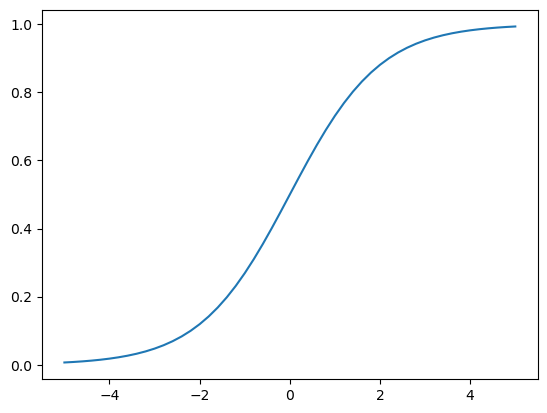

In [301]:
plt.plot(z, sigmoid(z))

In [302]:
def linear_regression(xi):
    result = w0
    
    for j in range(len(w)):
        result = result + xi[j] * w[j]
    
    return result

In [303]:
def logistic_regression(xi):
    score = w0
    
    for j in range(len(w)):
        score = score + xi[j] * w[j]
    
    result = sigmoid(score)
    return result

<h1>Training a Linear Regression Model with Scikit-Learn</h1>

In [304]:
from sklearn.linear_model import LogisticRegression

In [305]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [309]:
model.intercept_[0]

-0.10903162118335674

In [308]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.07 , -0.059,  0.141,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [312]:
# "hard" predictions (yes or no)
model.predict(X_train)

array([0, 1, 1, ..., 1, 0, 1])

In [314]:
# "soft" predictions
model.predict_proba(X_train)
# two columns: prob of 0 / prob of 1

array([[0.90453484, 0.09546516],
       [0.32065969, 0.67934031],
       [0.36631097, 0.63368903],
       ...,
       [0.46837111, 0.53162889],
       [0.95745284, 0.04254716],
       [0.30125458, 0.69874542]])

In [316]:
# use validation set to make predictions
y_pred = model.predict_proba(X_val)[:, 1] # just the right side

In [318]:
# convert to "hard" predictions at a certain threshold
churn_decision = (y_pred >= 0.5)

In [319]:
# grab customer id's of all people who are predicted to churn, so we can email them a promo
df_val[churn_decision].customerid

3       8433-wxgna
8       3440-jpscl
11      2637-fkfsy
12      7228-omtpn
19      6711-fldfb
           ...    
1397    5976-jcjrh
1398    2034-cgrhz
1399    5276-kqwhg
1407    6521-yytyi
1408    3049-solay
Name: customerid, Length: 311, dtype: object

In [321]:
# check accuracy of predictions
y_val

array([0, 0, 0, ..., 0, 1, 1])

In [322]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1])

In [325]:
# combine original y_val (actual churn data) with calculated churn_decision for validation set
# calculate mean for percentage correct
(y_val == churn_decision).mean()

0.8034066713981547

In [332]:
# "under the hood"
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [333]:
df_pred

,probability,prediction,actual,correct
0,0.008996,0,0,True
1,0.204539,0,0,True
2,0.212240,0,0,True
3,0.543053,1,1,True
4,0.213801,0,0,True
...,...,...,...,...
1404,0.313697,0,0,True
1405,0.039358,0,1,False
1406,0.136388,0,0,True
1407,0.799782,1,1,True


<h1>Model Interpretation</h1>

In [336]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [337]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.07 , -0.059,  0.141,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [344]:
# join the feature names with the coefficients to see weights
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

In [345]:
# make a smaller subset of data to train a small model on
small = ['contract', 'tenure', 'monthlycharges']

In [349]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [350]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

DictVectorizer(sparse=False)

In [351]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [352]:
X_train_small = dv_small.transform(dicts_train_small)

In [354]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [357]:
w0 = model_small.intercept_[0]
w0

-2.476775658979276

In [359]:
w = model_small.coef_[0]
w.round(3)

array([ 0.97 , -0.025, -0.949,  0.027, -0.036])

In [360]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': 0.97,
 'contract=one_year': -0.025,
 'contract=two_year': -0.949,
 'monthlycharges': 0.027,
 'tenure': -0.036}

<h1>Using the Model</h1>
<ol>
    <li>Get dictionaries from full training dataset</li>
    <li>Get feature matrix from dictionaries</li>
    <li>Train model on feature matrix</li>
    <li>Repeat for test dataset</li>
    <li>Get predictions</li>
    <li>Compute accuracy</li>
</ol>

In [362]:
# Get dictionaries
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [365]:
# Get feature matrix from dictionaries
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)
y_full_train = df_full_train.churn.values

In [367]:
# Train model
model = LogisticRegression()
model.fit(X_full_train, y_full_train)

LogisticRegression()

In [368]:
# Repeat for test dataset
dicts_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [372]:
# Get predictions
y_pred = model.predict_proba(X_test)[:, 1]
churn_decision = (y_pred >= 0.5) # can change threshold to suit your needs

In [374]:
# Compute accuracy -- This should not be too far off from validation accuracy
(churn_decision == y_test).mean()

0.815471965933286

Computing a churn score for an individual customer:

In [377]:
# grabbing hypothetical data for an existing test customer, could be a new customer
customer = dicts_test[10]
customer

{'gender': 'male',
 'seniorcitizen': 1,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'yes',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'mailed_check',
 'tenure': 32,
 'monthlycharges': 93.95,
 'totalcharges': 2861.45}

In [387]:
X_small = dv.transform([customer])

In [388]:
model.predict_proba(X_small)

array([[0.5943189, 0.4056811]])

In [389]:
# expected probability of churn
model.predict_proba(X_small)[0, 1] # the right column is the probability of target variable

0.4056810977850001

In [390]:
# actual churn result
y_test[10]

0

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\sydne\anaconda3\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sydne\anaconda3\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionReset